In [17]:
import matplotlib
import os
import numpy as np
import pandas as pd
import scipy.sparse
import matplotlib.pyplot as plt
import seaborn as sns
import time # For timing epochs

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Keras Tokenizer and pad_sequences are fine for preprocessing before PyTorch
from tensorflow.keras.preprocessing.text import Tokenizer as KerasTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.utils import to_categorical # Not needed if using CrossEntropyLoss with class indices

# PyTorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# 自定义模块
from data_preprocessing import (
    load_and_clean_data, tokenize_texts_jieba, vectorize_texts,
    train_word2vec_model, create_document_vectors_word2vec
)
from lda_model import train_lda, print_top_words
from classifiers import (
    get_multinomial_nb_classifier, get_gaussian_nb_classifier,
    get_svm_classifier, create_lstm_model # Updated to PyTorch LSTM
)
from evaluation import evaluate_model

# 设置绘图样式
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('muted')
pd.set_option('display.max_colwidth', 100) # 显示更宽的列内容
matplotlib.rcParams['font.family'] = 'SimHei'
# 解决负号显示为方块的问题
matplotlib.rcParams['axes.unicode_minus'] = False

## 1. 全局参数配置

In [3]:
DATA_DIR = "./data"  # 数据文件所在文件夹
MAX_FEATURES_BOW_TFIDF = 5000 # BoW 和 TF-IDF 的最大特征数
W2V_VECTOR_SIZE = 200       # Word2Vec 词向量维度
W2V_WINDOW = 5              # Word2Vec 上下文窗口
W2V_MIN_COUNT = 3           # Word2Vec 最小词频
W2V_SG = 0                  # 0 for CBOW, 1 for Skip-gram
N_TOPICS_LDA = 15           # LDA 主题数量

# LSTM 相关参数 (PyTorch)
MAX_VOCAB_SIZE_KERAS = 20000 # Keras Tokenizer 的最大词汇量 (used for PyTorch vocab_size too)
MAX_SEQUENCE_LENGTH = 250   # LSTM 输入序列最大长度
LSTM_EMBEDDING_DIM = W2V_VECTOR_SIZE # LSTM Embedding 维度
LSTM_HIDDEN_DIM = 128        # LSTM 隐层维度 (formerly LSTM_UNITS)
LSTM_N_LAYERS = 1            # Number of LSTM layers
LSTM_DROPOUT = 0.3
LSTM_BIDIRECTIONAL = True
LSTM_EPOCHS = 15             # Max epochs for PyTorch training loop
LSTM_BATCH_SIZE = 64
LSTM_LEARNING_RATE = 1e-3

TEST_SIZE_SPLIT = 0.2       # 测试集比例
RANDOM_STATE = 42           # 随机种子，保证结果可复现

# PyTorch Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Assuming 0 is used for padding by pad_sequences and KerasTokenizer reserves 0
PAD_IDX_FOR_EMBEDDING = 0

Using device: cuda


## 2. 数据加载与初步清洗

In [4]:
texts, labels = load_and_clean_data(DATA_DIR)
print(f"总共加载文本数: {len(texts)}")
print(f"总共加载标签数: {len(labels)}")
print(f"标签类别数量: {len(set(labels))}")

if texts:
    print("\n前3个文本示例:")
    for i in range(min(3, len(texts))):
        print(f"  文本 {i+1}: {texts[i][:100]}...")
        print(f"  标签 {i+1}: {labels[i]}")
else:
    print("未能加载任何数据，请检查 DATA_DIR 和数据文件。")

总共加载文本数: 82210
总共加载标签数: 82210
标签类别数量: 12

前3个文本示例:
  文本 1: 2022年12月7日，（微信号：；农行卡：；建行卡：；中行卡；邮储卡：）在家中添加了一个微信好友（微信号：），后将其录入一个微信刷单群（已解散）。后按照群内指示下载了“乐橙”APP，并在该APP“发现...
  标签 1: 刷单返利类
  文本 2: 2022年12月15日，报案人向110报警称：2021年3月8日21时00分至2022年10月20日19时00分之间，（微信：，昵称：帅）在，认识案犯甲（微信：，昵称：），案犯甲自称是股票行业的专家，...
  标签 2: 虚假网络投资理财类
  文本 3: 2022年111月11日，接报警称其在家中，于当天晚上18时左右接到陌生电话对方自称时快递客服人员，称因疫情原因要销毁快递并会给我进行补偿，后下载了一个“会讯通云会议”APP，后称其操作失误银行卡冻结...
  标签 3: 冒充电商物流客服类


## 3. 标签编码

In [5]:
label_encoder = LabelEncoder()
y_numeric = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)
print(f"\n标签编码完成。类别数量: {num_classes}")
print(f"类别映射: {dict(zip(label_encoder.classes_, range(num_classes)))}")


标签编码完成。类别数量: 12
类别映射: {'冒充公检法及政府机关类': 0, '冒充军警购物类诈骗': 1, '冒充电商物流客服类': 2, '冒充领导、熟人类': 3, '刷单返利类': 4, '网络婚恋、交友类（非虚假网络投资理财类）': 5, '网络游戏产品虚假交易类': 6, '网黑案件': 7, '虚假征信类': 8, '虚假网络投资理财类': 9, '虚假购物、服务类': 10, '贷款、代办信用卡类': 11}


## 4. 文本分词 (使用 Jieba)

In [6]:
print("\n开始文本分词...")
# 分词
texts_tokenized = tokenize_texts_jieba(texts)

# 分词后用空格连接 (用于 Scikit-learn Vectorizers)
texts_joined = [" ".join(tokens) for tokens in texts_tokenized]
print(f"分词完成。前1个分词后用空格连接的文本: {texts_joined[0][:100]}...")

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\zr\AppData\Local\Temp\jieba.cache



开始文本分词...


Loading model cost 0.577 seconds.
Prefix dict has been built successfully.


分词完成。前1个分词后用空格连接的文本: 2022 年 12 月 7 日 ， （ 微 信号 ： ； 农行 卡 ： ； 建行 卡 ： ； 中行 卡 ； 邮储 卡 ： ） 在 家中 添加 了 一个 微信 好友 （ 微 信号 ： ） ， 后 将 其...


## 5. 特征工程

### 5.1. 词袋 (BoW) 特征

In [7]:
print("\n正在生成词袋 (BoW) 特征...")
features_bow, vectorizer_bow = vectorize_texts(texts_joined, method="count", max_features=MAX_FEATURES_BOW_TFIDF)
print(f"BoW 特征矩阵形状: {features_bow.shape}")


正在生成词袋 (BoW) 特征...
BoW 特征矩阵形状: (82210, 5000)


### 5.2. TF-IDF 特征

In [8]:
print("\n正在生成 TF-IDF 特征...")
features_tfidf, vectorizer_tfidf = vectorize_texts(texts_joined, method="tfidf", max_features=MAX_FEATURES_BOW_TFIDF)
print(f"TF-IDF 特征矩阵形状: {features_tfidf.shape}")


正在生成 TF-IDF 特征...
TF-IDF 特征矩阵形状: (82210, 5000)


### 5.3. Word2Vec 特征 (平均词向量)

首先，在整个文本语料上训练 Word2Vec 模型。然后，为每篇文档计算其包含的所有词的词向量的平均值，作为该文档的向量表示。

In [9]:
print("\n正在训练 Word2Vec 模型...")
w2v_model = train_word2vec_model(texts_tokenized,
                                 vector_size=W2V_VECTOR_SIZE,
                                 window=W2V_WINDOW,
                                 min_count=W2V_MIN_COUNT,
                                 sg=W2V_SG, workers=os.cpu_count())
print("Word2Vec 模型训练完成。")

print("\n正在生成 Word2Vec 文档向量...")
features_w2v = create_document_vectors_word2vec(texts_tokenized, w2v_model)
print(f"Word2Vec 文档向量矩阵形状: {features_w2v.shape}")


正在训练 Word2Vec 模型...
Word2Vec 模型训练完成。

正在生成 Word2Vec 文档向量...
Word2Vec 文档向量矩阵形状: (82210, 200)


### 5.4. LDA 主题模型特征
LDA 模型通常在词频矩阵 (BoW) 上训练效果较好。

In [10]:
print("\n正在训练 LDA 模型 (基于 BoW 特征)...")
# 使用 BoW 特征训练 LDA
lda_model, topic_distributions = train_lda(features_bow, n_topics=N_TOPICS_LDA, random_state=RANDOM_STATE)
print(f"LDA 主题分布矩阵形状: {topic_distributions.shape}")

# 打印 LDA 主题词
bow_feature_names = vectorizer_bow.get_feature_names_out()
print_top_words(lda_model, bow_feature_names, n_top_words=10)


正在训练 LDA 模型 (基于 BoW 特征)...
LDA 主题分布矩阵形状: (82210, 15)

--- LDA Top Words per Topic ---
Topic #0:
户名 卡号 银行卡 有限公司 银行 2022 对方 农村 转账 信用社
Topic #1:
嫌疑人 受害人 银行卡 户主 2022 账号 通过 信息 转账 诈骗
Topic #2:
贷款 对方 app 银行卡 客服 转账 下载 需要 解冻 一个
Topic #3:
对方 京东 电话 账户 转账 客服 贷款 2022 接到 报警
Topic #4:
受害人 对方 银行卡 一个 电话 银行 账户 转账 之后 然后
Topic #5:
转账 2022 对方 银行卡 卡号 12 11 通过 10 银行
Topic #6:
对方 投资 2022 app 提现 报警 平台 账户 进行 充值
Topic #7:
app 对方 转账 账户 银行 卡号 下载 2022 刷单 微信
Topic #8:
对方 账号 开户 账户 转账 银行 开户行 客服 通过 昵称
Topic #9:
对方 电话 快递 2022 客服 支付宝 接到 转账 银行卡 一个
Topic #10:
对方 2022 报警 转账 微信 信号 账户 通过 12 11
Topic #11:
被害人 报警 2022 对方 接到 银行卡 诈骗 开户名 电话 转账
Topic #12:
事主 对方 账号 一个 转账 银行 app 信息 银行卡 人民币
Topic #13:
对方 报警 qq 一个 2022 微信 转账 添加 qq号 通过
Topic #14:
对方 一个 任务 之后 提现 app 然后 可以 下载 充值
--- End LDA Top Words ---



### 5.5. 组合特征
将 LDA 主题分布与 BoW, TF-IDF, Word2Vec 特征分别组合。

In [11]:
print("\n正在创建组合特征...")
# BoW + LDA
features_bow_lda = scipy.sparse.hstack((features_bow, topic_distributions)).tocsr()
print(f"BoW + LDA 特征矩阵形状: {features_bow_lda.shape}")

# TF-IDF + LDA
features_tfidf_lda = scipy.sparse.hstack((features_tfidf, topic_distributions)).tocsr()
print(f"TF-IDF + LDA 特征矩阵形状: {features_tfidf_lda.shape}")

# Word2Vec + LDA (两者都是稠密矩阵)
features_w2v_lda = np.hstack((features_w2v, topic_distributions))
print(f"Word2Vec + LDA 特征矩阵形状: {features_w2v_lda.shape}")


正在创建组合特征...
BoW + LDA 特征矩阵形状: (82210, 5015)
TF-IDF + LDA 特征矩阵形状: (82210, 5015)
Word2Vec + LDA 特征矩阵形状: (82210, 215)


### 5.6. LSTM 数据准备
LSTM 需要将文本转换为固定长度的整数序列。标签也需要转换为类别格式 (one-hot)。

In [12]:
print("\n正在为 LSTM 准备数据...")
keras_tokenizer = KerasTokenizer(num_words=MAX_VOCAB_SIZE_KERAS, oov_token="<unk>")
keras_tokenizer.fit_on_texts([' '.join(doc) for doc in texts_tokenized])

sequences = keras_tokenizer.texts_to_sequences([' '.join(doc) for doc in texts_tokenized])
X_lstm_padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post', value=PAD_IDX_FOR_EMBEDDING) # Ensure padding value is PAD_IDX_FOR_EMBEDDING
print(f"LSTM 输入序列形状: {X_lstm_padded.shape}")


word_index_keras = keras_tokenizer.word_index
actual_vocab_size_for_embedding = MAX_VOCAB_SIZE_KERAS

embedding_matrix_w2v_lstm = np.zeros((actual_vocab_size_for_embedding, W2V_VECTOR_SIZE))
for word, i in word_index_keras.items():
    if i < actual_vocab_size_for_embedding: # Ensure index is within bounds
        if word in w2v_model.wv:
            embedding_matrix_w2v_lstm[i] = w2v_model.wv[word]

print(f"Keras Tokenizer effective vocab size for embedding: {actual_vocab_size_for_embedding}")
print(f"Word2Vec 预训练嵌入矩阵形状 (for LSTM): {embedding_matrix_w2v_lstm.shape}")


正在为 LSTM 准备数据...
LSTM 输入序列形状: (82210, 250)
Keras Tokenizer effective vocab size for embedding: 20000
Word2Vec 预训练嵌入矩阵形状 (for PyTorch LSTM): (20000, 200)


## 6. 模型训练与评估

将对以下特征组合和模型进行评估：
-   **Naive Bayes (MultinomialNB/GaussianNB)**: BoW, TF-IDF, Word2Vec, BoW+LDA, TF-IDF+LDA, Word2Vec+LDA
-   **SVM (LinearSVC)**: BoW, TF-IDF, Word2Vec, BoW+LDA, TF-IDF+LDA, Word2Vec+LDA
-   **LSTM**:
    1.  使用随机初始化的 Embedding 层
    2.  使用 Word2Vec 预训练的 Embedding 层 (不可训练)
    3.  使用 Word2Vec 预训练的 Embedding 层 (可微调)

In [13]:
all_results = []

# 定义经典分类器的特征集
feature_sets_classical = {
    "BoW": features_bow,
    "TF-IDF": features_tfidf,
    "Word2Vec": features_w2v,
    "BoW + LDA": features_bow_lda,
    "TF-IDF + LDA": features_tfidf_lda,
    "Word2Vec + LDA": features_w2v_lda
}

# --- 6.1 经典分类器 (Naive Bayes, SVM)
for fs_name, X_features in feature_sets_classical.items():
    print(f"\n{'='*20}评估特征集: {fs_name}{'='*20}")

    X_train, X_test, y_train_num_classical, y_test_num_classical = train_test_split(
        X_features, y_numeric, test_size=TEST_SIZE_SPLIT,
        random_state=RANDOM_STATE, stratify=y_numeric
    )

    # 朴素贝叶斯
    if "Word2Vec" in fs_name or (isinstance(X_features, np.ndarray) and not np.all(X_features >= 0)):
        nb_classifier = get_gaussian_nb_classifier()
        model_name_nb = "GaussianNB"
        if scipy.sparse.issparse(X_train):
            X_train_nb = X_train.toarray()
            X_test_nb = X_test.toarray()
        else:
            X_train_nb, X_test_nb = X_train, X_test
    else:
        nb_classifier = get_multinomial_nb_classifier()
        model_name_nb = "MultinomialNB"
        X_train_nb, X_test_nb = X_train, X_test

    print(f"\nTraining {model_name_nb} on {fs_name}...")
    nb_classifier.fit(X_train_nb, y_train_num_classical)
    y_pred_nb = nb_classifier.predict(X_test_nb)
    results_nb = evaluate_model(y_test_num_classical, y_pred_nb, target_names=label_encoder.classes_,
                                model_name=model_name_nb, feature_type=fs_name)
    all_results.append(results_nb)

    # SVM (LinearSVC)
    print(f"\nTraining SVM (LinearSVC) on {fs_name}...")
    svm_classifier = get_svm_classifier(max_iter=2000)
    svm_classifier.fit(X_train, y_train_num_classical)
    y_pred_svm = svm_classifier.predict(X_test)
    results_svm = evaluate_model(y_test_num_classical, y_pred_svm, target_names=label_encoder.classes_,
                                 model_name="SVM (LinearSVC)", feature_type=fs_name)
    all_results.append(results_svm)


# --- 6.2 LSTM 分类器 ---
print(f"\n{'='*20}评估 PyTorch LSTM 模型{'='*20}")

# Split data for LSTM
X_train_lstm_np, X_test_lstm_np, y_train_lstm_num, y_test_lstm_num = train_test_split(
    X_lstm_padded, y_numeric, test_size=TEST_SIZE_SPLIT,
    random_state=RANDOM_STATE, stratify=y_numeric
)

# Convert to PyTorch Tensors
X_train_lstm_tensor = torch.tensor(X_train_lstm_np, dtype=torch.long).to(DEVICE)
y_train_lstm_tensor = torch.tensor(y_train_lstm_num, dtype=torch.long).to(DEVICE) # Use Long for CrossEntropyLoss
X_test_lstm_tensor = torch.tensor(X_test_lstm_np, dtype=torch.long).to(DEVICE)
y_test_lstm_tensor = torch.tensor(y_test_lstm_num, dtype=torch.long).to(DEVICE)

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_lstm_tensor, y_train_lstm_tensor)
test_dataset = TensorDataset(X_test_lstm_tensor, y_test_lstm_tensor)

train_loader = DataLoader(train_dataset, batch_size=LSTM_BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=LSTM_BATCH_SIZE, shuffle=False)


# --- Training and Evaluation Function ---
def train_eval_model(model, model_name_suffix, train_loader, test_loader, y_test_actual_num,
                             optimizer, criterion, epochs, device, label_encoder_classes):
    model.to(device)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_loss = float('inf')
    epochs_no_improve = 0
    patience = 3 # For early stopping

    for epoch in range(epochs):
        epoch_start_time = time.time()
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)

        # Validation
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        all_val_preds = []

        with torch.no_grad():
            for inputs, labels in test_loader: # Using test_loader as validation loader
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                all_val_preds.extend(predicted.cpu().numpy())


        epoch_val_loss = running_val_loss / total_val
        epoch_val_acc = correct_val / total_val
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        epoch_duration = time.time() - epoch_start_time
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} - "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f} - "
              f"Duration: {epoch_duration:.2f}s")

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
            # torch.save(model.state_dict(), f'best_model_{model_name_suffix}.pth') # 保存最佳模型
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f"Early stopping triggered after epoch {epoch+1}")
                break

    # 在测试集上进行评估
    model.eval() # Ensure model is in eval mode
    final_preds = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            final_preds.extend(predicted.cpu().numpy())

    results_metrics = evaluate_model(y_test_actual_num, np.array(final_preds),
                                     target_names=label_encoder_classes,
                                     model_name="LSTM", feature_type=model_name_suffix)
    return results_metrics, history


# --- LSTM 1:LSTM with Learned Embeddings ---
print("\nTraining LSTM (Learned Embeddings)...")
model_lstm_learned_pt = create_lstm_model(
    vocab_size=actual_vocab_size_for_embedding,
    embedding_dim=LSTM_EMBEDDING_DIM,
    hidden_dim=LSTM_HIDDEN_DIM,
    num_classes=num_classes,
    n_layers=LSTM_N_LAYERS,
    bidirectional=LSTM_BIDIRECTIONAL,
    dropout_rate=LSTM_DROPOUT,
    pad_idx=PAD_IDX_FOR_EMBEDDING
)
print(model_lstm_learned_pt)
optimizer_learned = optim.Adam(model_lstm_learned_pt.parameters(), lr=LSTM_LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

results_lstm_learned_pt, history_learned_pt = train_eval_model(
    model_lstm_learned_pt, "Learned Embeddings", train_loader, test_loader, y_test_lstm_num,
    optimizer_learned, criterion, LSTM_EPOCHS, DEVICE, label_encoder.classes_
)
all_results.append(results_lstm_learned_pt)


# --- LSTM 2: LSTM with Word2Vec Pre-trained Embeddings (Non-trainable) ---
print("\nTraining  LSTM (Word2Vec Fixed Embeddings)...")
model_lstm_w2v_fixed_pt = create_lstm_model(
    vocab_size=actual_vocab_size_for_embedding,
    embedding_dim=W2V_VECTOR_SIZE, # Use W2V_VECTOR_SIZE for embedding_dim
    hidden_dim=LSTM_HIDDEN_DIM,
    num_classes=num_classes,
    n_layers=LSTM_N_LAYERS,
    bidirectional=LSTM_BIDIRECTIONAL,
    dropout_rate=LSTM_DROPOUT,
    embedding_matrix=embedding_matrix_w2v_lstm,
    trainable_embedding=False, # Key: Non-trainable
    pad_idx=PAD_IDX_FOR_EMBEDDING
)
print(model_lstm_w2v_fixed_pt)
optimizer_w2v_fixed = optim.Adam(model_lstm_w2v_fixed_pt.parameters(), lr=LSTM_LEARNING_RATE)
# criterion is the same

results_lstm_w2v_fixed_pt, history_w2v_fixed_pt = train_eval_model(
    model_lstm_w2v_fixed_pt, "Word2Vec Fixed", train_loader, test_loader, y_test_lstm_num,
    optimizer_w2v_fixed, criterion, LSTM_EPOCHS, DEVICE, label_encoder.classes_
)
all_results.append(results_lstm_w2v_fixed_pt)


# --- LSTM 3: LSTM with Word2Vec Pre-trained Embeddings (Fine-tuned) ---
print("\nTraining LSTM (Word2Vec Fine-tuned Embeddings)...")
model_lstm_w2v_finetune_pt = create_lstm_model(
    vocab_size=actual_vocab_size_for_embedding,
    embedding_dim=W2V_VECTOR_SIZE, # Use W2V_VECTOR_SIZE
    hidden_dim=LSTM_HIDDEN_DIM,
    num_classes=num_classes,
    n_layers=LSTM_N_LAYERS,
    bidirectional=LSTM_BIDIRECTIONAL,
    dropout_rate=LSTM_DROPOUT,
    embedding_matrix=embedding_matrix_w2v_lstm,
    trainable_embedding=True, # Key: Fine-tune
    pad_idx=PAD_IDX_FOR_EMBEDDING
)
print(model_lstm_w2v_finetune_pt)
optimizer_w2v_finetune = optim.Adam(model_lstm_w2v_finetune_pt.parameters(), lr=LSTM_LEARNING_RATE)

results_lstm_w2v_finetune_pt, history_w2v_finetune_pt = train_eval_model(
    model_lstm_w2v_finetune_pt, "Word2Vec Fine-tuned", train_loader, test_loader, y_test_lstm_num,
    optimizer_w2v_finetune, criterion, LSTM_EPOCHS, DEVICE, label_encoder.classes_
)
all_results.append(results_lstm_w2v_finetune_pt)


====================评估特征集: BoW====================

Training MultinomialNB on BoW...
--- Performance: MultinomialNB on BoW ---
Accuracy: 0.8433
Precision (Weighted): 0.8564
Recall (Weighted): 0.8433
F1 Score (Weighted): 0.8446
Precision (Macro): 0.7672
Recall (Macro): 0.8235
F1 Score (Macro): 0.7845

Classification Report:
                       precision    recall  f1-score   support

         冒充公检法及政府机关类       0.90      0.82      0.86       730
           冒充军警购物类诈骗       0.52      0.97      0.68       175
           冒充电商物流客服类       0.89      0.67      0.77      2204
            冒充领导、熟人类       0.88      0.85      0.86       705
               刷单返利类       0.94      0.93      0.94      5673
网络婚恋、交友类（非虚假网络投资理财类）       0.37      0.49      0.42       265
         网络游戏产品虚假交易类       0.72      0.92      0.81       344
                网黑案件       0.91      0.97      0.94       192
               虚假征信类       0.69      0.95      0.80      1354
           虚假网络投资理财类       0.82      0.86      0.84 

## 7. 结果汇总与分析

In [14]:
results_df = pd.DataFrame(all_results)
results_df_display = results_df[['Model', 'Features', 'Accuracy', 'Precision (Weighted)', 'Recall (Weighted)', 'F1 Score (Weighted)', 'F1 Score (Macro)']]
results_df_display = results_df_display.sort_values(by=['Model', 'Accuracy'], ascending=[True, False])

print("\n" + "="*30 + " 综合评估结果 " + "="*30)
print(results_df_display.to_string())


============================== 综合评估结果 ==============================
              Model                       Features  Accuracy  Precision (Weighted)  Recall (Weighted)  F1 Score (Weighted)  F1 Score (Macro)
10       GaussianNB                 Word2Vec + LDA  0.657037              0.732902           0.657037             0.684436          0.542660
4        GaussianNB                       Word2Vec  0.500608              0.625792           0.500608             0.538243          0.424131
0     MultinomialNB                            BoW  0.843328              0.856393           0.843328             0.844634          0.784548
6     MultinomialNB                      BoW + LDA  0.842355              0.855337           0.842355             0.843658          0.782411
8     MultinomialNB                   TF-IDF + LDA  0.827880              0.833375           0.827880             0.819641          0.745698
2     MultinomialNB                         TF-IDF  0.815108              0.821140  

### 7.1. 结果可视化
绘制条形图比较不同模型和特征组合的性能 (例如，比较 F1 分数)。

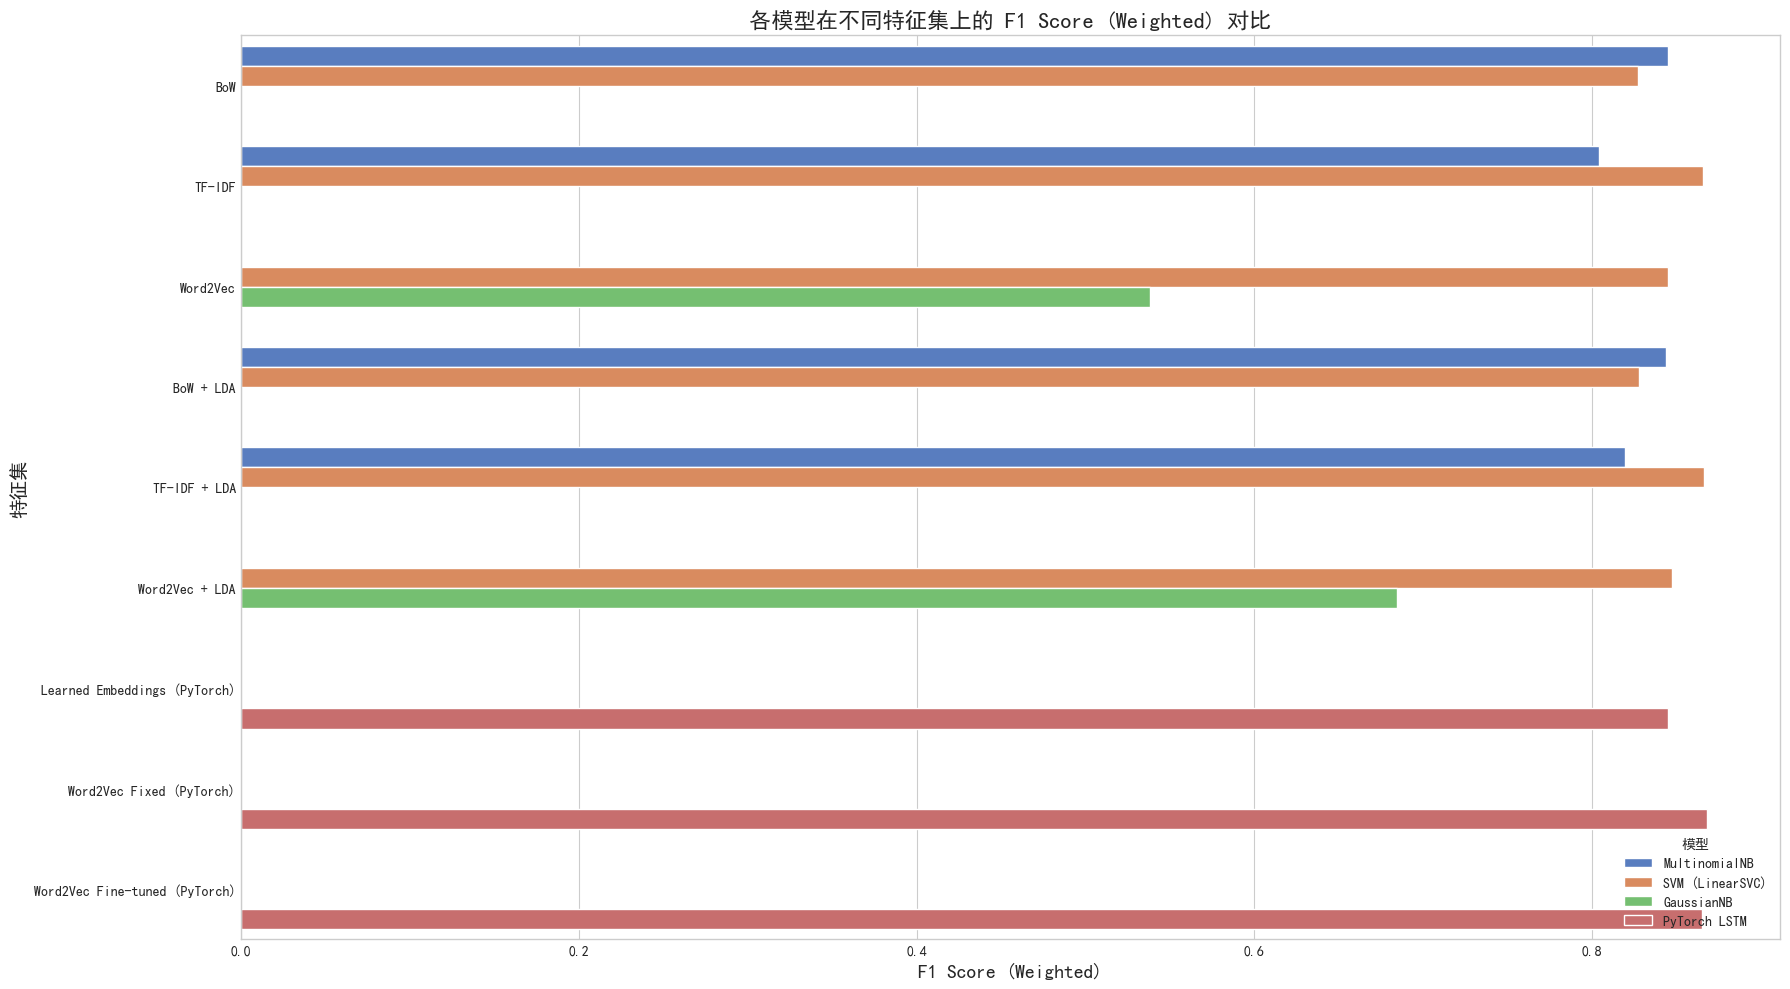

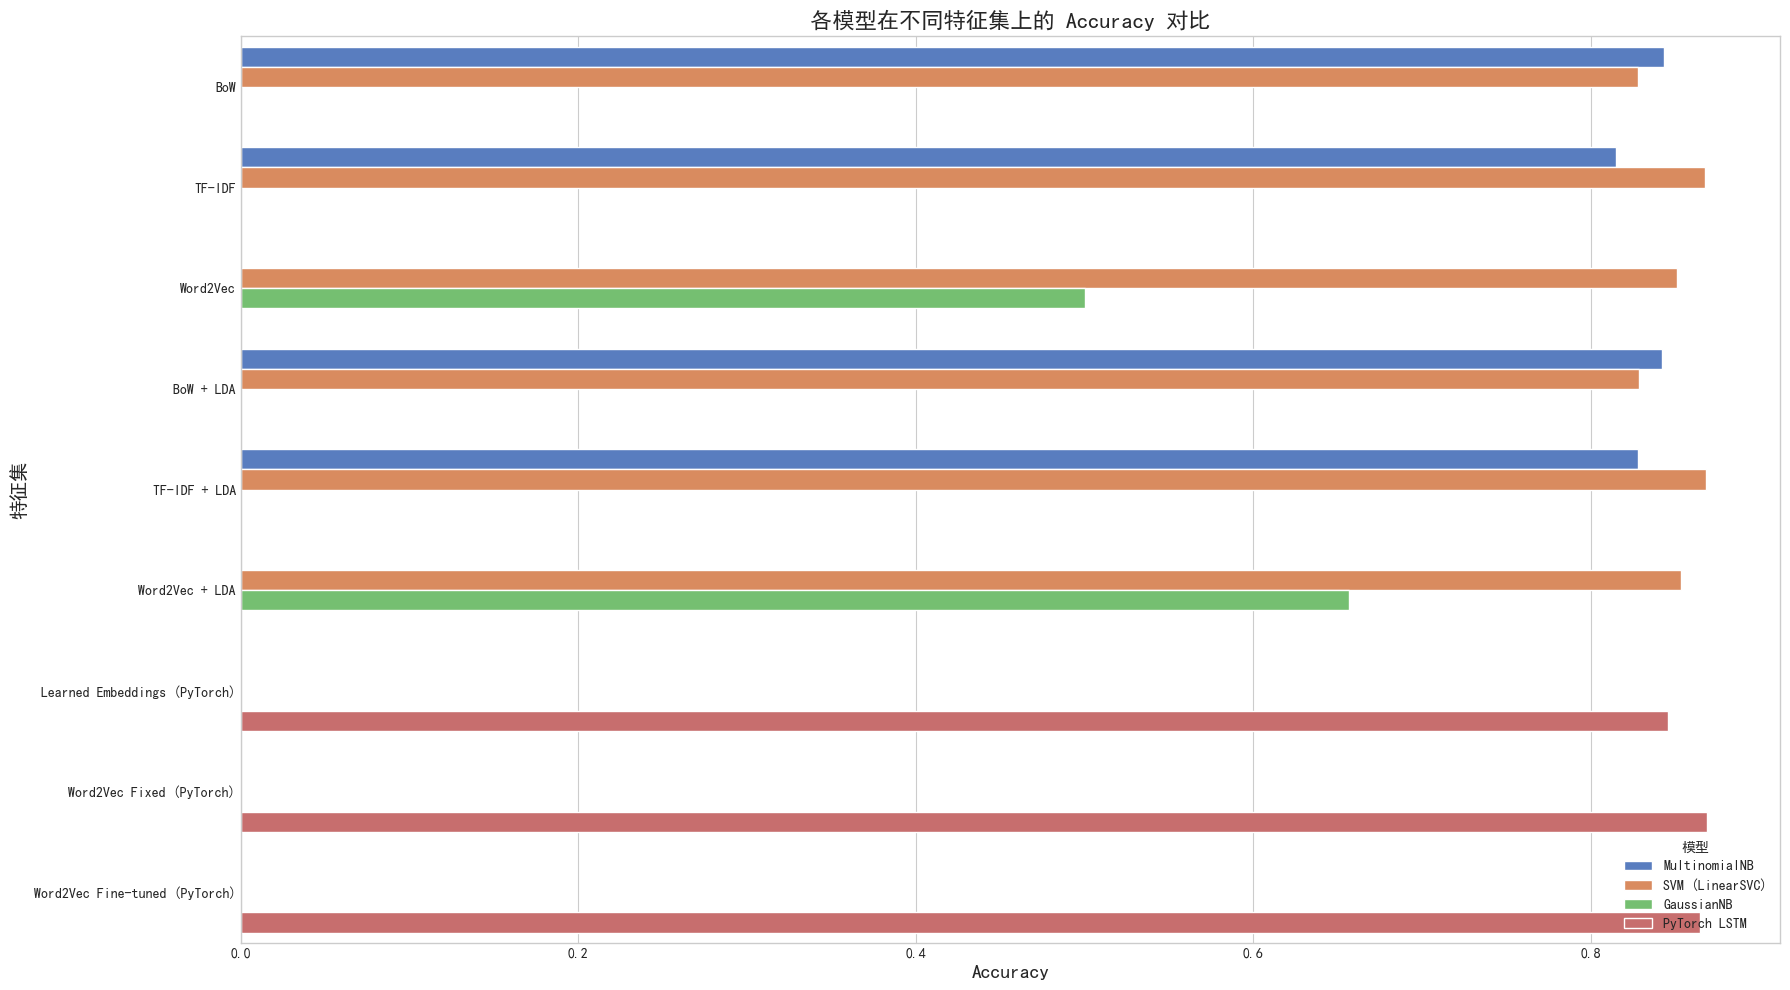

In [18]:
# 确保 DataFrame 中有数据再绘图
if not results_df.empty:
    plt.figure(figsize=(18, 10))
    sns.barplot(x='F1 Score (Weighted)', y='Features', hue='Model', data=results_df, orient='h')
    plt.title('各模型在不同特征集上的 F1 Score (Weighted) 对比', fontsize=16)
    plt.xlabel('F1 Score (Weighted)', fontsize=14)
    plt.ylabel('特征集', fontsize=14)
    plt.legend(title='模型', loc='lower right')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(18, 10))
    sns.barplot(x='Accuracy', y='Features', hue='Model', data=results_df, orient='h')
    plt.title('各模型在不同特征集上的 Accuracy 对比', fontsize=16)
    plt.xlabel('Accuracy', fontsize=14)
    plt.ylabel('特征集', fontsize=14)
    plt.legend(title='模型', loc='lower right')
    plt.tight_layout()
    plt.show()
else:
    print("结果 DataFrame 为空，无法生成图表。")

### 7.2. LSTM 训练历史可视化

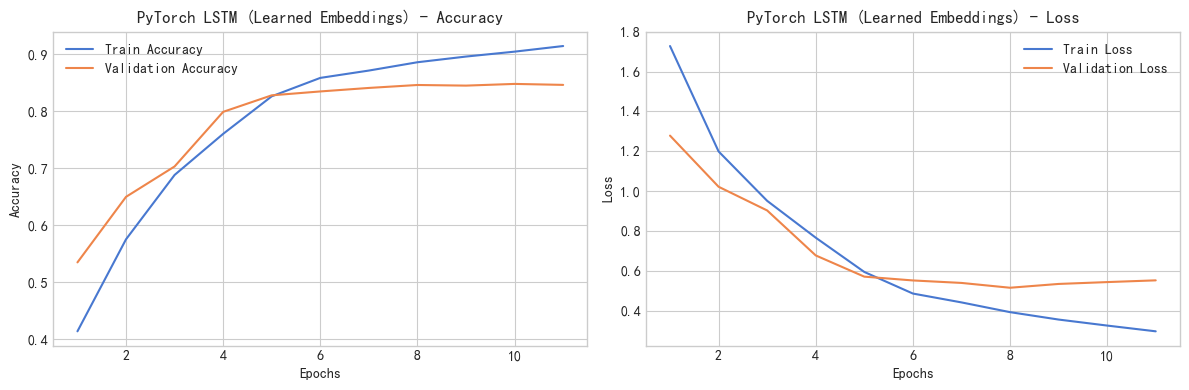

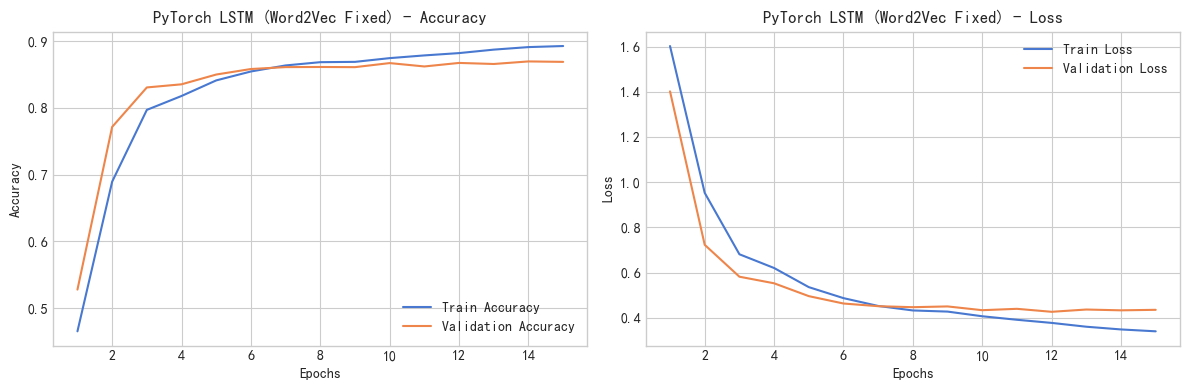

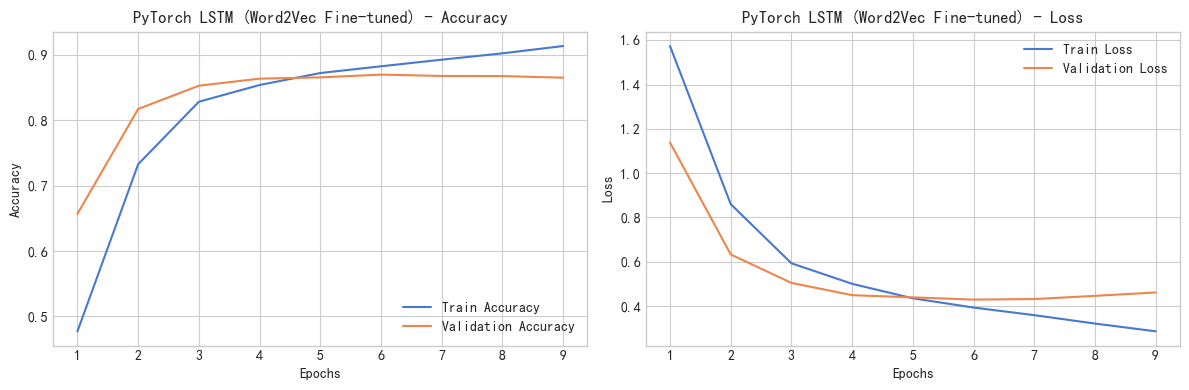

In [19]:
def plot_lstm_history(history_dict, model_name_suffix):
    if not history_dict or not all(k in history_dict for k in ['train_acc', 'val_acc', 'train_loss', 'val_loss']):
        print(f"History dictionary for {model_name_suffix} is incomplete or missing.")
        return

    epochs_ran = len(history_dict['train_acc'])
    if epochs_ran == 0:
        print(f"No epochs were run for {model_name_suffix}.")
        return

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs_ran + 1), history_dict['train_acc'], label='Train Accuracy')
    plt.plot(range(1, epochs_ran + 1), history_dict['val_acc'], label='Validation Accuracy')
    plt.title(f'PyTorch LSTM ({model_name_suffix}) - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs_ran + 1), history_dict['train_loss'], label='Train Loss')
    plt.plot(range(1, epochs_ran + 1), history_dict['val_loss'], label='Validation Loss')
    plt.title(f'PyTorch LSTM ({model_name_suffix}) - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

if 'history_learned_pt' in locals(): plot_lstm_history(history_learned_pt, "Learned Embeddings")
if 'history_w2v_fixed_pt' in locals(): plot_lstm_history(history_w2v_fixed_pt, "Word2Vec Fixed")
if 'history_w2v_finetune_pt' in locals(): plot_lstm_history(history_w2v_finetune_pt, "Word2Vec Fine-tuned")